Bike sharing polynomial features
---

Exercise - Load and split the data, set the baseline
---

> **Exercise**: Load the dataset. Encode categorical variables with one-hot encoding. Split the data into train/test sets with the `train_test_split()` function from Scikit-learn (50-50 split, `random_state=0`). Fit a linear regression and compare its performance to the median baseline using the mean absolute error (MAE) measure.

In [1]:
import pandas as pd
import os

# Load data
data_df = pd.read_csv("c3_bike-sharing-data.csv")
data_df.head()

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.160,2011,no,no,6,spring,cloudy,331
1,0.363,0.696,0.249,2011,no,no,0,spring,cloudy,131
2,0.196,0.437,0.248,2011,yes,no,1,spring,clear,120
3,0.200,0.590,0.160,2011,yes,no,2,spring,clear,108
4,0.227,0.437,0.187,2011,yes,no,3,spring,clear,82


In [2]:
# One-hot encoding
encoded_df = pd.get_dummies(
    data_df, columns=["yr", "workingday", "holiday", "weekday", "season", "weathersit"]
)
encoded_df.head()

,temp,hum,windspeed,casual,yr_2011,yr_2012,workingday_no,workingday_yes,holiday_no,holiday_yes,...,weekday_4,weekday_5,weekday_6,season_fall,season_spring,season_summer,season_winter,weathersit_clear,weathersit_cloudy,weathersit_rainy
0,0.344,0.806,0.160,331,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
1,0.363,0.696,0.249,131,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0.196,0.437,0.248,120,1,0,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0.200,0.590,0.160,108,1,0,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
4,0.227,0.437,0.187,82,1,0,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0


In [3]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
train_df, test_df = train_test_split(
    encoded_df, train_size=0.5, test_size=0.5, random_state=0
)

print("Train DataFrame:", train_df.shape)
print("Test DataFrame:", test_df.shape)

Train DataFrame: (365, 24)
Test DataFrame: (366, 24)


In [4]:
# Create X/y variables
X_tr = train_df.drop("casual", axis=1).values
y_tr = train_df.casual.values

X_te = test_df.drop("casual", axis=1).values
y_te = test_df.casual.values

In [5]:
import numpy as np

# Mean absolute error (MAE)
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [6]:
from sklearn.linear_model import LinearRegression, Ridge

# Function to fit the model
def fit_model(X_train, y_train, X_test):
    # Create the model
    # Note: Using ridge with a small alpha to avoid ill-conditioning issues
    model = Ridge(alpha=1e-4)  # or LinearRegression()

    # Fit it to train data
    model.fit(X_train, y_train)

    # Compute predictions for test set
    y_pred = np.maximum(model.predict(X_test), 50)  # set a lower limit

    return y_pred

In [7]:
# Median baseline
mae_baseline = MAE(y_te, np.median(y_tr))

# Linear regression
y_pred = fit_model(X_tr, y_tr, X_te)
mae_lr = MAE(y_te, y_pred)

print("MAE baseline: {:.3f}".format(mae_baseline))
print("MAE linear regression: {:.3f}".format(mae_lr))

MAE baseline: 503.574
MAE linear regression: 246.866


Exercise - Add polynomial features
---

> **Exercise**: Add the `temp^2` and `temp^3` polynomial features. Then fit and evaluate a linear regression. Plot your model with a scatter plot of temperatures vs. number of users. Feel free to add other features.

In [8]:
# Function to add features
def create_features(df):
    temp = df.temp.values
    others = df.drop(["temp", "casual"], axis=1).values
    return np.c_[temp, temp ** 2, temp ** 3, others]

In [9]:
# Create new input matrices
X_tr2 = create_features(train_df)
X_te2 = create_features(test_df)

# Fit a linear regression
y_pred_lr = fit_model(X_tr2, y_tr, X_te2)
mae_lr2 = MAE(y_te, y_pred_lr)
print("MAE lr with new features: {:.3f}".format(mae_lr2))

MAE lr with new features: 224.400


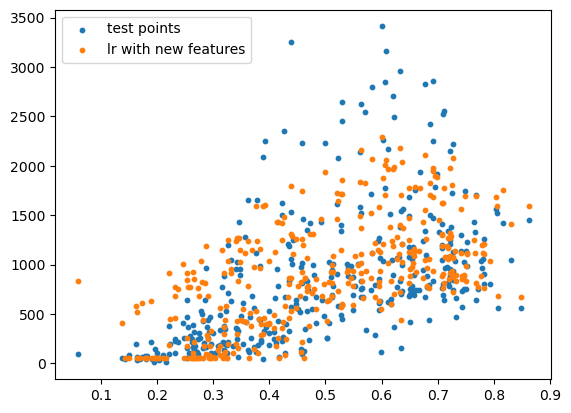

In [11]:
# Plot predictions
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(test_df.temp, test_df.casual, s=10, label="test points")
plt.scatter(test_df.temp, y_pred_lr, s=10, label="lr with new features")
plt.legend()
plt.show()

Exercise - Separate sources
---

In the last exercise, we saw that we can identify two sources in the data.

1. Data points collected during working days
1. Data points collected during non-working days

The goal of this exercise is to create a model for each source using your extended set of features, e.g., the original features plus the `temp^2`, `temp^3` polynomial features.

> **Exercise**: Create a model for each source with the extended set of features, and evaluate the overall performance on the test set using MAE. Plot the two models with a scatter plot of temperatures vs. number of users. Create a final comparison using a bar chart.

In [12]:
# Split data into working days (wd) and non-working days (nwd)
train_df_wd = train_df[train_df.workingday_yes == 1]
train_df_nwd = train_df[train_df.workingday_yes == 0]

test_df_wd = test_df[test_df.workingday_yes == 1]
test_df_nwd = test_df[test_df.workingday_yes == 0]

In [13]:
# Fit two linear regressions
y_pred_wd = fit_model(
    create_features(train_df_wd), train_df_wd.casual, create_features(test_df_wd)
)
y_pred_nwd = fit_model(
    create_features(train_df_nwd), train_df_nwd.casual, create_features(test_df_nwd)
)

# Reassemble predictions
y_pred_wdnwd = np.concatenate([y_pred_wd, y_pred_nwd])
y_te_wdnwd = np.concatenate([test_df_wd.casual, test_df_nwd.casual])

# Compute MAE
mae_wdnwd = MAE(y_te_wdnwd, y_pred_wdnwd)
print("MAE two sources: {:.3f}".format(mae_wdnwd))

MAE two sources: 178.718


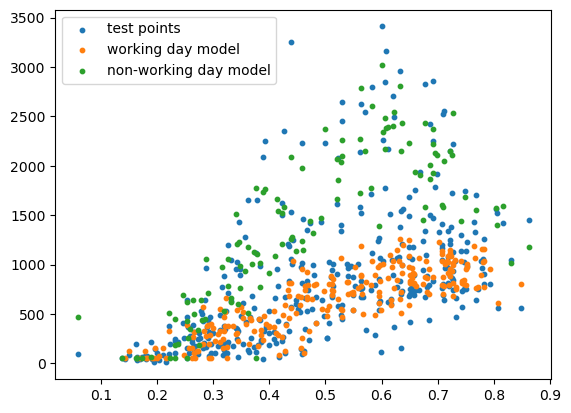

In [14]:
# Plot predictions
temp_te_wdnwd = np.concatenate([test_df_wd.temp, test_df_nwd.temp])
plt.scatter(temp_te_wdnwd, y_te_wdnwd, s=10, label="test points")
plt.scatter(test_df_wd.temp, y_pred_wd, s=10, label="working day model")
plt.scatter(test_df_nwd.temp, y_pred_nwd, s=10, label="non-working day model")

plt.legend()
plt.show()

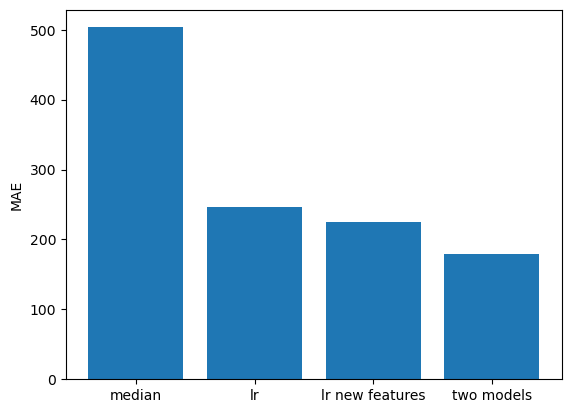

In [15]:
# Final comparison
mae_values = [mae_baseline, mae_lr, mae_lr2, mae_wdnwd]
titles = ["median", "lr", "lr new features", "two models"]

plt.bar(titles, mae_values)

plt.ylabel("MAE")
plt.show()